In [1]:
import numpy as np 
import pandas as pd 
import itertools
import os
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf

from sklearn.preprocessing import LabelBinarizer, LabelEncoder
from sklearn.metrics import confusion_matrix
from tensorflow import keras
layers = keras.layers
models = keras.models

# Pada program ini menggunakan TensorFlow v1.8
print("Anda menggunakan tensorflow versi : ", tf.__version__)

Anda menggunakan tensorflow versi :  1.8.0


In [2]:
data = pd.read_csv("../input/bbc-text.csv")

In [3]:
data.head()

,category,text
0,tech,tv future in the hands of viewers with home th...
1,business,worldcom boss left books alone former worldc...
2,sport,tigers wary of farrell gamble leicester say ...
3,sport,yeading face newcastle in fa cup premiership s...
4,entertainment,ocean s twelve raids box office ocean s twelve...


In [4]:
data['category'].value_counts()

sport            511
business         510
politics         417
tech             401
entertainment    386
Name: category, dtype: int64

## Mulai melakukan persiapan environment training dan dataset

In [5]:
train_size = int(len(data) * .8)
print ("Train size: %d" % train_size)
print ("Test size: %d" % (len(data) - train_size))

Train size: 1780
Test size: 445


In [6]:
def train_test_split(data, train_size):
    train = data[:train_size]
    test = data[train_size:]
    return train, test

In [7]:
train_cat, test_cat = train_test_split(data['category'], train_size)
train_text, test_text = train_test_split(data['text'], train_size)

In [8]:
max_words = 1000
tokenize = keras.preprocessing.text.Tokenizer(num_words=max_words, 
                                              char_level=False)

In [9]:
tokenize.fit_on_texts(train_text)
x_train = tokenize.texts_to_matrix(train_text)
x_test = tokenize.texts_to_matrix(test_text)

In [10]:
encoder = LabelEncoder()
encoder.fit(train_cat)
y_train = encoder.transform(train_cat)
y_test = encoder.transform(test_cat)

In [11]:
num_classes = np.max(y_train) + 1
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

In [12]:
print('Ukuran x_train:', x_train.shape)
print('Ukuran x_test:', x_test.shape)
print('Ukuran y_train:', y_train.shape)
print('Ukuran y_test:', y_test.shape)

Ukuran x_train: (1780, 1000)
Ukuran x_test: (445, 1000)
Ukuran y_train: (1780, 5)
Ukuran y_test: (445, 5)


In [13]:
batch_size = 32
epochs = 2
drop_ratio = 0.5

## Mulai membangun model training

In [14]:
# Memulai proses build model
model = models.Sequential()
model.add(layers.Dense(512, input_shape=(max_words,)))
model.add(layers.Activation('relu'))
model.add(layers.Dense(num_classes))
model.add(layers.Activation('softmax'))

model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

In [15]:
history = model.fit(x_train, y_train,
                    batch_size=batch_size,
                    epochs=epochs,
                    verbose=1,
                    validation_split=0.1)

Train on 1602 samples, validate on 178 samples
Epoch 1/2
1602/1602 [==============================] - 1s 534us/step - loss: 0.4442 - acc: 0.8695 - val_loss: 0.1550 - val_acc: 0.9438
Epoch 2/2
1602/1602 [==============================] - 0s 287us/step - loss: 0.0508 - acc: 0.9894 - val_loss: 0.1188 - val_acc: 0.9494


## Evaluasi model

In [16]:
# Mulai melakukan tindakan evaluasi terhadap hasil akurasi yang dimiliki oleh model yang sudah dilakukan training
score = model.evaluate(x_test, y_test,
                       batch_size=batch_size, verbose=1)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

445/445 [==============================] - 0s 70us/step
Test loss: 0.15931060207
Test accuracy: 0.950561799226


## Memulai Hyperparameter Tuning

In [17]:
def run_experiment(batch_size, epochs, drop_ratio):
  print('batch size: {}, epochs: {}, drop_ratio: {}'.format(
      batch_size, epochs, drop_ratio))
  model = models.Sequential()
  model.add(layers.Dense(512, input_shape=(max_words,)))
  model.add(layers.Activation('relu'))
  model.add(layers.Dropout(drop_ratio))
  model.add(layers.Dense(num_classes))
  model.add(layers.Activation('softmax'))

  model.compile(loss='categorical_crossentropy',
                optimizer='adam',
                metrics=['accuracy'])
  history = model.fit(x_train, y_train,
                    batch_size=batch_size,
                    epochs=epochs,
                    verbose=0,
                    validation_split=0.1)
  score = model.evaluate(x_test, y_test,
                       batch_size=batch_size, verbose=0)
  print('\tTest loss:', score[0])
  print('\tTest accuracy:', score[1])

In [18]:
batch_size = 16
epochs = 4
drop_ratio = 0.4
run_experiment(batch_size, epochs, drop_ratio)

batch size: 16, epochs: 4, drop_ratio: 0.4
	Test loss: 0.118453610312
	Test accuracy: 0.955056179909


## Melakukan Prediksi menggunakan Model


In [19]:
# Memulai melakukan prediksi hasil terhadap dataset yang ada
text_labels = encoder.classes_ 
for i in range(10):
    prediction = model.predict(np.array([x_test[i]]))
    predicted_label = text_labels[np.argmax(prediction)]
    print(test_text.iloc[i][:50], "...")
    print('Label awal: ' + test_cat.iloc[i])
    print("Label hasil prediksi: " + predicted_label + "\n")  

hobbit picture  four years away  lord of the rings ...
Label awal: entertainment
Label hasil prediksi: entertainment

game firm holds  cast  auditions video game firm b ...
Label awal: tech
Label hasil prediksi: tech

clarke plans migrant point scheme anyone planning  ...
Label awal: politics
Label hasil prediksi: politics

radcliffe will compete in london paula radcliffe w ...
Label awal: sport
Label hasil prediksi: sport

serena becomes world number two serena williams ha ...
Label awal: sport
Label hasil prediksi: sport

ultimate game  award for doom 3 sci-fi shooter doo ...
Label awal: tech
Label hasil prediksi: tech

algeria hit by further gas riots algeria suffered  ...
Label awal: business
Label hasil prediksi: business

fast lifts rise into record books two high-speed l ...
Label awal: tech
Label hasil prediksi: tech

muslim group attacks tv drama 24 a british muslim  ...
Label awal: entertainment
Label hasil prediksi: entertainment

us tv special for tsunami relief a us televi

## Melakukan visualisasi pada confusion matrix

In [20]:
y_softmax = model.predict(x_test)

y_test_1d = []
y_pred_1d = []

for i in range(len(y_test)):
    probs = y_test[i]
    index_arr = np.nonzero(probs)
    one_hot_index = index_arr[0].item(0)
    y_test_1d.append(one_hot_index)

for i in range(0, len(y_softmax)):
    probs = y_softmax[i]
    predicted_index = np.argmax(probs)
    y_pred_1d.append(predicted_index)

In [21]:
def plot_confusion_matrix(cm, classes,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    
    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title, fontsize=30)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45, fontsize=22)
    plt.yticks(tick_marks, classes, fontsize=22)

    fmt = '.2f'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('Label awal : ', fontsize=25)
    plt.xlabel('Label prediksi : ', fontsize=25)

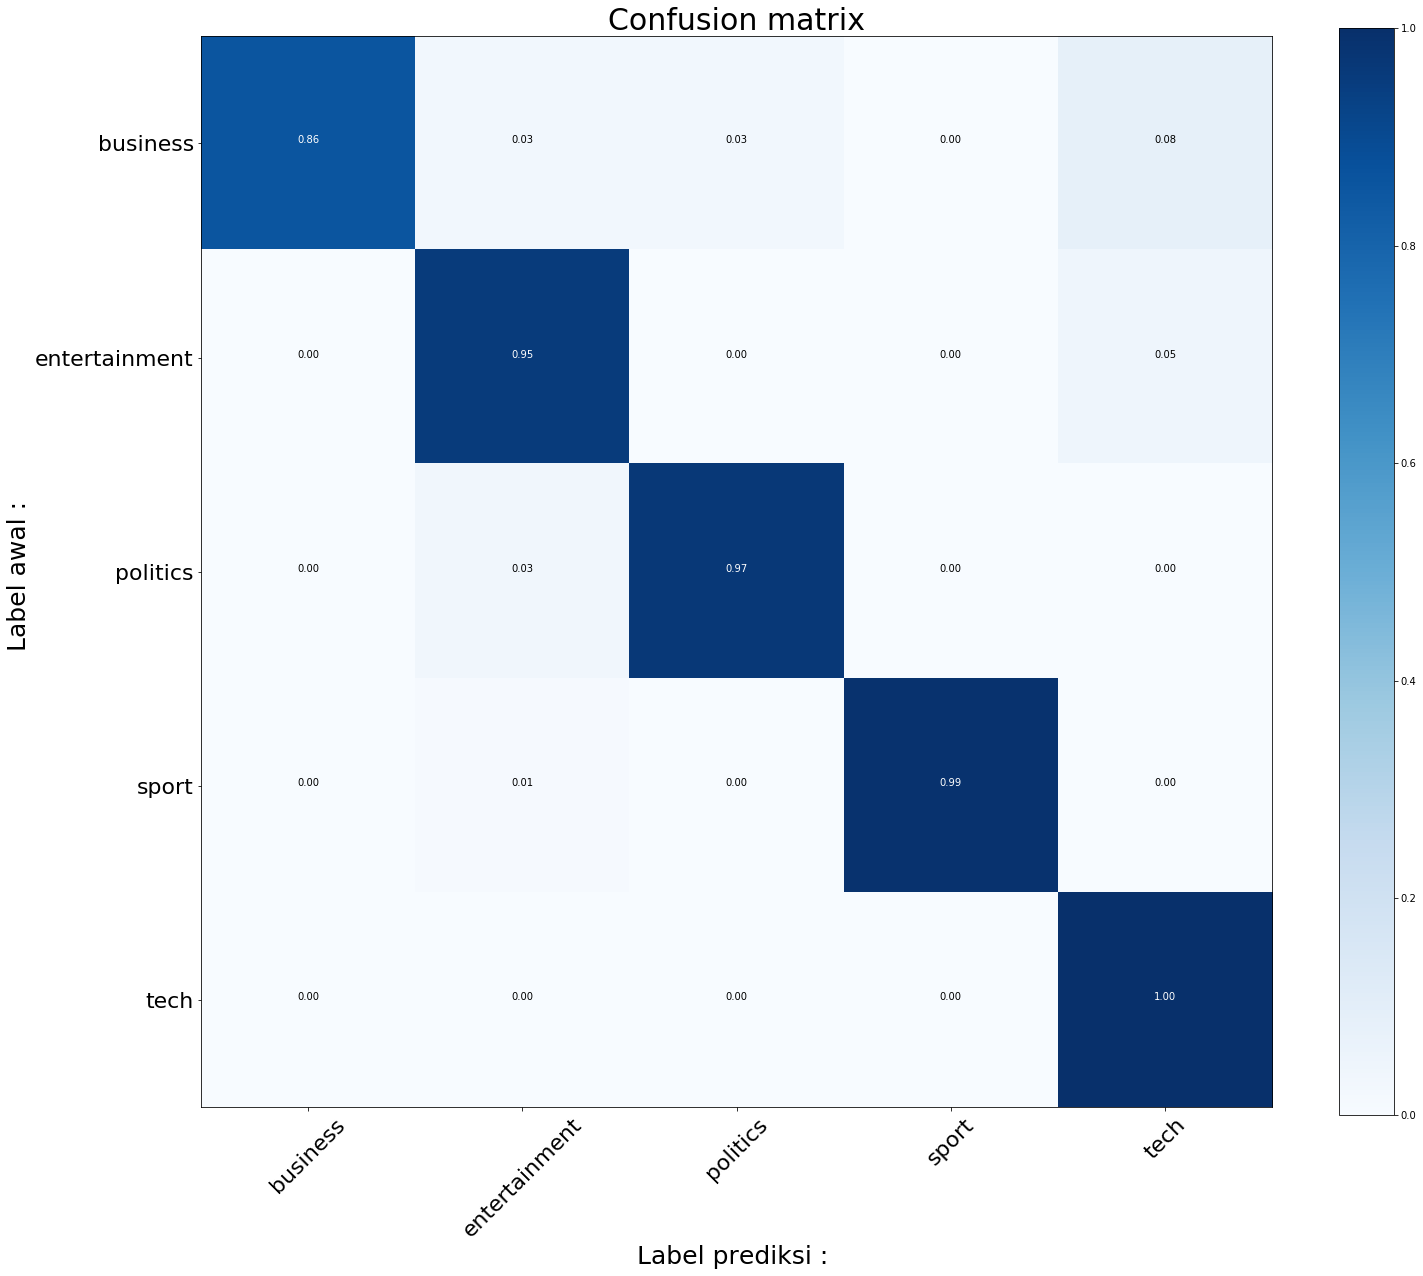

In [22]:
cnf_matrix = confusion_matrix(y_test_1d, y_pred_1d)
plt.figure(figsize=(24,20))
plot_confusion_matrix(cnf_matrix, classes=text_labels, title="Confusion matrix")
plt.show()